## Setup ##

In [1]:
!pip install tifffile 
!pip install scikit-image

  Running setup.py bdist_wheel for futures ... done
  Stored in directory: /root/.cache/pip/wheels/f3/f9/c7/4fbf1faa6038faf183f6e3ea61f17a5f7eea5ab9a1dd7753fd
Successfully built futures
You are using pip version 9.0.3, however version 10.0.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 10.0.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
# imports 
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F 
import torch.optim as optim

import numpy as np 
from skimage import measure 
import tifffile 


import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
matplotlib.rcParams['axes.grid'] = False

In [ ]:
# # get data 
# !wget https://storage.googleapis.com/seunglab/tmacrina/crack_detector/180401_pinky100_negative_gt_image.tif
# !wget https://storage.googleapis.com/seunglab/tmacrina/crack_detector/180401_pinky100_negative_gt_label.tif
# !wget https://storage.googleapis.com/seunglab/tmacrina/crack_detector/180401_pinky100_positive_gt_image.tif
# !wget https://storage.googleapis.com/seunglab/tmacrina/crack_detector/180401_pinky100_positive_gt_label.tif

In [2]:
positive_images = tifffile.imread('180417_basil_positive_image.tif').astype(np.float32)
positive_images = positive_images - np.mean(positive_images, axis=(1,2)).reshape((-1,1,1)) # normalize inputs
positive_images = positive_images / (np.std(positive_images, axis=(1,2)).reshape((-1,1,1)) + 1e-6)
negative_images = tifffile.imread('180417_basil_negative_image.tif').astype(np.float32)
negative_images = negative_images - np.mean(negative_images, axis=(1,2)).reshape((-1,1,1)) # normalize inputs
negative_images = negative_images / (np.std(negative_images, axis=(1,2)).reshape((-1,1,1)) + 1e-6)

positive_labels = tifffile.imread('180417_basil_positive_fold.tif').astype(np.float32)
positive_include = (positive_labels[:,0,0] != 255)
positive_images = positive_images[positive_include]
positive_labels = positive_labels[positive_include]
positive_labels = (positive_labels == 1).astype(np.float32)
negative_labels = tifffile.imread('180417_basil_negative_fold.tif').astype(np.float32)
negative_include = (negative_labels[:,0,0] != 255)
negative_images = negative_images[negative_include]
negative_labels = negative_labels[negative_include]
negative_labels = (negative_labels == 1).astype(np.float32)

pos_perm = np.random.permutation(len(positive_images))
neg_perm = np.random.permutation(len(negative_images))
np.savetxt('180417_positive_indices.csv', pos_perm)
np.savetxt('180417_negative_indices.csv', neg_perm)

# pos_perm = np.genfromtxt('180417_positive_indices.csv').astype(np.int)
# neg_perm = np.genfromtxt('180417_negative_indices.csv').astype(np.int)

In [3]:
pos_perm.shape

(1192,)

In [4]:
neg_perm.shape

(450,)

In [5]:
pos_idx = 750 
neg_idx = 250

images_trn = np.concatenate((positive_images[pos_perm[:pos_idx]], negative_images[neg_perm[:neg_idx]]))
labels_trn = np.concatenate((positive_labels[pos_perm[:pos_idx]], negative_labels[neg_perm[:neg_idx]]))

images_val = np.concatenate((positive_images[pos_perm[pos_idx:]], negative_images[neg_perm[neg_idx:]]))
labels_val = np.concatenate((positive_labels[pos_perm[pos_idx:]], negative_labels[neg_perm[neg_idx:]]))

## Visualize Data ##

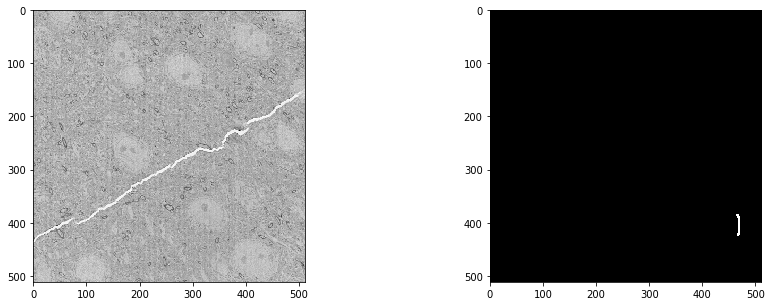

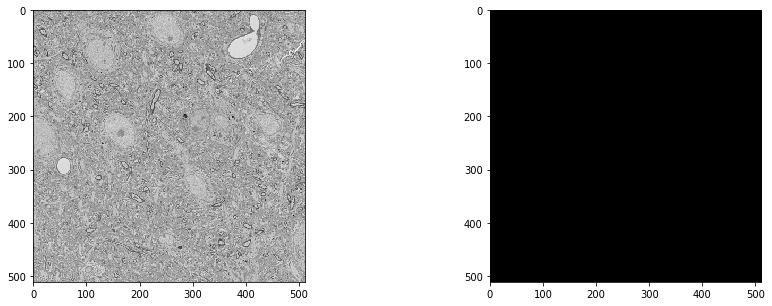

In [8]:
#@title Default title text
# visualize data
k = 12
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(images_trn[k], cmap='gray')
plt.subplot(122)
plt.imshow(labels_trn[k], cmap='gray')
plt.grid(False)
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(images_val[k], cmap='gray')
plt.subplot(122)
plt.imshow(labels_val[k], cmap='gray')
plt.show()

## Create UNet ##

In [9]:
# helper operations 
def conv3x3(in_channels, out_channels):
    return nn.Conv2d(in_channels, out_channels,
        kernel_size=3, stride=1, padding=1, bias=True)

def maxpool2x2():
    return nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

class UpConv2x2(nn.Module):
    def __init__(self, channels):
        super(UpConv2x2, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2)
        self.conv = nn.Conv2d(channels, channels // 2,
            kernel_size=2, stride=1, padding=0, bias=True)

    def forward(self, x):
        x = self.upsample(x)
        x = F.pad(x, (0,1,0,1))
        x = self.conv(x)
        return x 
        
def concat(xh, xv):
    return torch.cat([xh, xv], dim=1)


# unet blocks
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Args:
            in_channels: number of channels in input (1st) feature map
            out_channels: number of channels in output feature maps
        """
        super(ConvBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.conv3 = conv3x3(out_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x

class DownConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Args:
            in_channels: number of channels in input (1st) feature map
            out_channels: number of channels in output feature maps
        """
        super(DownConvBlock, self).__init__()
        self.maxpool = maxpool2x2()
        self.conv1 = conv3x3(in_channels, out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.conv3 = conv3x3(out_channels, out_channels)

    def forward(self, x):
        x = self.maxpool(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x

class UpConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Args:
            in_channels: number of channels in input (1st) feature map
            out_channels: number of channels in output feature maps
        """
        super(UpConvBlock, self).__init__()
        self.upconv = UpConv2x2(in_channels)
        self.conv1 = conv3x3(in_channels, out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.conv3 = conv3x3(out_channels, out_channels)

    def forward(self, xh, xv):
        """
        Args:
            xh: torch Variable, activations from same resolution feature maps (gray arrow in diagram)
            xv: torch Variable, activations from lower resolution feature maps (green arrow in diagram)
        """
        xv = self.upconv(xv)
        x = concat(xh, xv)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        fs = [16,32,64,128,256]
        self.conv_in = ConvBlock(1, fs[0])
        self.dconv1 = DownConvBlock(fs[0], fs[1])
        self.dconv2 = DownConvBlock(fs[1], fs[2])
        self.dconv3 = DownConvBlock(fs[2], fs[3])
        self.dconv4 = DownConvBlock(fs[3], fs[4])

        self.uconv1 = UpConvBlock(fs[4], fs[3])
        self.uconv2 = UpConvBlock(fs[3], fs[2])
        self.uconv3 = UpConvBlock(fs[2], fs[1])
        self.uconv4 = UpConvBlock(fs[1], fs[0])
        self.conv_out = conv3x3(fs[0], 1)

        self._initialize_weights()

    def forward(self, x):
        x1 = self.conv_in(x)
        x2 = self.dconv1(x1)
        x3 = self.dconv2(x2)
        x4 = self.dconv3(x3)
        x5 = self.dconv4(x4)
        x6 = self.uconv1(x4, x5)
        x7 = self.uconv2(x3, x6)
        x8 = self.uconv3(x2, x7)
        x9 = self.uconv4(x1, x8)
        x10 = self.conv_out(x9)
        return x10

    def _initialize_weights(self):
        conv_modules = [m for m in self.modules() if isinstance(m, nn.Conv2d)]
        for m in conv_modules:
          n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
          m.weight.data.normal_(0, np.sqrt(2. / n))


## Train UNet ##

In [10]:
# train utils
def np2var(arr, cuda):
    arr = np.expand_dims(np.expand_dims(arr, 0), 0)
    arr = torch.from_numpy(arr)
    arr = Variable(arr)
    if cuda:
        arr = arr.cuda()
    return arr

def var2np(arr):
    arr = arr.data.cpu().numpy()[0,0]
    return arr
    

In [11]:
# plot utils
def plot_learning(plot_handles, ylabel):
    plt.legend(handles=plot_handles, loc="center right")
    plt.xlabel("Iterations")
    plt.ylabel(ylabel)

def plot(step, log_every, train_loss, val_loss, img_trn, img_val, pred_trn, pred_val, true_trn, true_val):
    clear_output(wait=False)
    plt.gcf().clear()
    
    ax = plt.subplot(241)
    iters = np.arange(0,len(train_loss))*log_every
    train_plot, = plt.plot(iters, train_loss, 'r', label="training")
    val_plot, = plt.plot(iters, val_loss, 'b', label="validation")
    plot_learning([train_plot, val_plot], "Loss")
    plt.title("Cross entropy loss")
    ax.set_yscale("log")

    plt.subplot(242)
    plt.imshow(img_trn, cmap='gray')
    plt.title("Input image, train")
    
    plt.subplot(243)
    plt.imshow(pred_trn, cmap='gray')
    plt.title("Predicted, train")
    
    
    plt.subplot(244)
    plt.imshow(true_trn, cmap='gray')
    plt.title("True, train")
    
    plt.subplot(246)
    plt.imshow(img_val, cmap='gray')
    plt.title("Input image, val")
    
    plt.subplot(247)
    plt.imshow(pred_val, cmap='gray')
    plt.title("Predicted, val")
    
    
    plt.subplot(248)
    plt.imshow(true_val, cmap='gray')
    plt.title("True, val")


    plt.gcf().set_size_inches(18, 7)
    display(plt.gcf())

In [12]:
trial = 180417

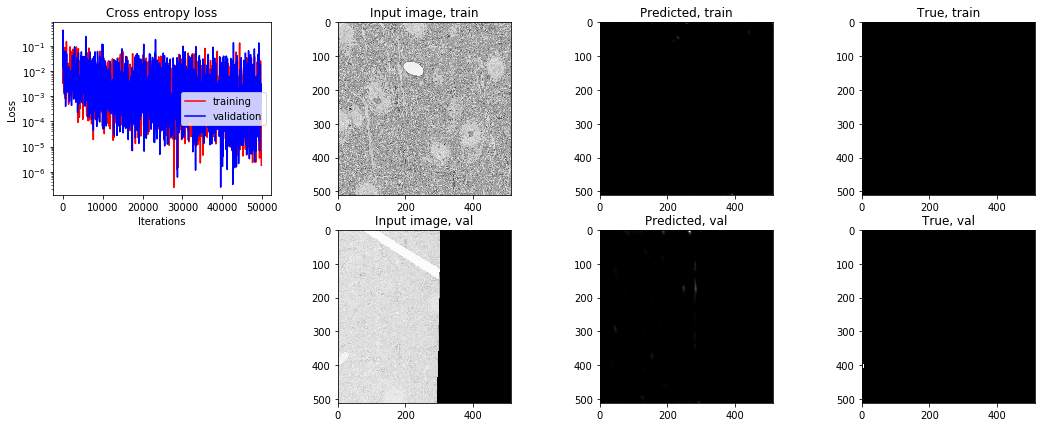

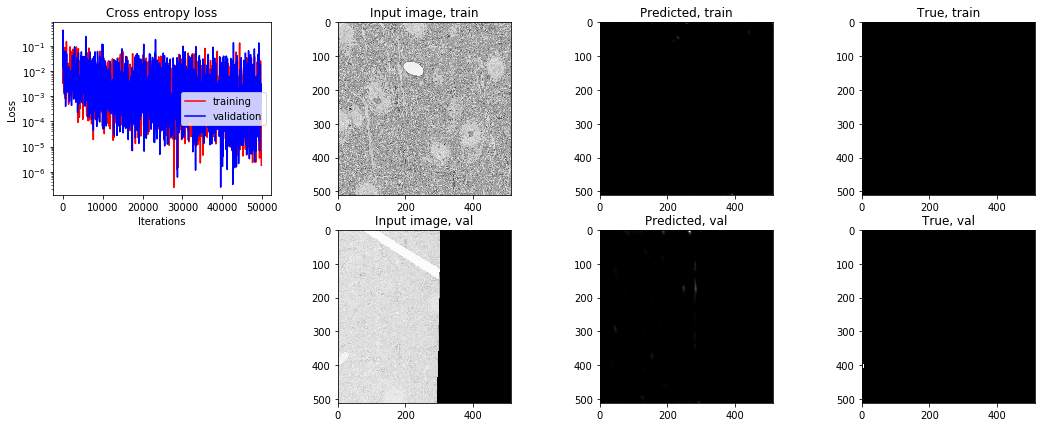

In [13]:
## Train network ##

# params
USECUDA = True
max_iter = 50000
log_every = 50
plot_every = 200
lr = 0.00005

# create net
net = UNet()
if USECUDA:
    net.cuda()
    
# create optimizer 
optimizer = optim.Adam(net.parameters(), lr=lr)

# train net
losses_trn = []
losses_val = []
for t in range(max_iter):
    # choose sample
    idx = np.random.randint(0,images_trn.shape[0])
    img, label = images_trn[idx], labels_trn[idx]
    
    # flip
    p = np.random.randint(0,3)
    if p > 1:
        img = np.flip(img,axis=1).copy()
        label = np.flip(label,axis=1).copy()
    if p > 0:
        img = np.flip(img,axis=0).copy()
        label = np.flip(label,axis=0).copy()
    
    # format
    img = np2var(img, cuda=USECUDA)
    label = np2var(label, cuda=USECUDA)
    
    # forward, backward, update
    optimizer.zero_grad()
    pred = net(img)
    loss = F.binary_cross_entropy_with_logits(pred, label)
    loss.backward()
    optimizer.step()
    

    # log stuff
    if t % log_every == 0: 
        # validation info
        idx = np.random.randint(0,images_val.shape[0])
        img_val, label_val = images_val[idx], labels_val[idx]

        # flip
        p = np.random.randint(0,3)
        if p > 1:
            img_val = np.flip(img_val,axis=1).copy()
            label_val = np.flip(label_val,axis=1).copy()
        if p > 0:
            img_val = np.flip(img_val,axis=0).copy()
            label_val = np.flip(label_val,axis=0).copy()
        
        # format
        img_val = np2var(img_val, cuda=USECUDA)
        label_val = np2var(label_val, cuda=USECUDA)

        # forward
        pred_val = net(img_val)
        loss_val = F.binary_cross_entropy_with_logits(pred_val, label_val)

        # store
        losses_trn.append(loss.data[0])
        losses_val.append(loss_val.data[0])
        
    # plot stuff
    if t % plot_every == 0:
        plot(t, log_every, losses_trn, losses_val, 
             var2np(img), var2np(img_val),
             var2np(F.sigmoid(pred)), var2np(F.sigmoid(pred_val)),
             var2np(label), var2np(label_val))
    
    

In [14]:
PATH = 'basil_folddetector_unet{}'.format(trial)
torch.save(net, PATH)
trial += 1

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type ConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type DownConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type UpConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/pyth

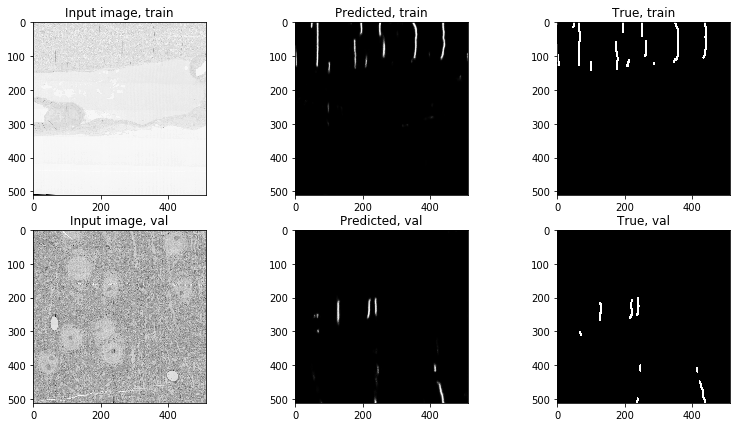

In [28]:
idx = np.random.randint(0,images_trn.shape[0])
img, label = images_trn[idx], labels_trn[idx]
img = np2var(img, cuda=USECUDA)
label = np2var(label, cuda=USECUDA)
pred = net(img)

img_trn = var2np(img)
pred_trn = var2np(F.sigmoid(pred))
true_trn = var2np(label)

idx = np.random.randint(0,images_val.shape[0])
img_val, label_val = images_val[idx], labels_val[idx]
img_val = np2var(img_val, cuda=USECUDA)
label_val = np2var(label_val, cuda=USECUDA)
pred_val = net(img_val)

img_val = var2np(img_val)
pred_val = var2np(F.sigmoid(pred_val))
true_val = var2np(label_val)

plt.subplot(242)
plt.imshow(img_trn, cmap='gray')
plt.title("Input image, train")

plt.subplot(243)
plt.imshow(pred_trn, cmap='gray')
plt.title("Predicted, train")


plt.subplot(244)
plt.imshow(true_trn, cmap='gray')
plt.title("True, train")

plt.subplot(246)
plt.imshow(img_val, cmap='gray')
plt.title("Input image, val")

plt.subplot(247)
plt.imshow(pred_val, cmap='gray')
plt.title("Predicted, val")


plt.subplot(248)
plt.imshow(true_val, cmap='gray')
plt.title("True, val")


plt.gcf().set_size_inches(18, 7)
# display(plt.gcf())